In [1]:
import sys
import os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
sys.path.append('./libs')

import ats_xdmf as ats_xdmf
import ats_vis as atsvis
import h5py
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider, Dropdown
import pandas as pd 

try:
    import colorcet as cc
except ImportError:
    !{sys.executable} -m pip install colorcet
    import colorcet as cc
    

# Specify simulation result folder and load data

In [2]:
data_directory = './results'

# load subsurface domain (None means subsurface) visualization
vis_domain = ats_xdmf.VisFile(data_directory, domain=None, output_time_unit='d')
vis_domain.loadMeshPolygons()
vis_domain.loadMesh()

# load surface domain visualization
vis_surface = ats_xdmf.VisFile(data_directory, domain='surface', output_time_unit='d')
vis_surface.loadMesh(order=['x','z'])

# Create data structure for visualization

In [3]:
data_groups = {
    "Flow": {
        "var_surface": "surface-ponded_depth",
        "unit_surface": "m",
        "vmin_surface": 1e-4,
        "vmax_surface": 10,        
        "log_surface": True,        
        "var_domain": "saturation_liquid",
        "unit_domain": "-",
        "vmin_domain": 0.5,
        "vmax_domain": 1,
        "log_domain": False,
        "cmap": "jet_r",
        "plot_ponding": True,
    },
    "Tracer 1": {
        "var_surface": "surface-mole_fraction.Tracer1",
        "unit_surface": "molC/molH2O",
        "vmin_surface": 1e-5,
        "vmax_surface": 1e-1,                
        "log_surface": True,
                
        "var_domain": "mole_fraction.Tracer1",
        "unit_domain": "molC/molH2O",
        "vmin_domain": 1e-6,
        "vmax_domain": 1e-2,
        "log_domain": True,
        "cmap": cc.cm.CET_R4,
        "plot_ponding": False,
    },
    "Tracer 2": {
        "var_surface": "surface-mole_fraction.Tracer2",
        "unit_surface": "molC/molH2O",
        "vmin_surface": None,
        "vmax_surface": 1e-1,                
        "log_surface": True,
                
        "var_domain": "mole_fraction.Tracer2",
        "unit_domain": "molC/molH2O",
        "vmin_domain": 1e-6,
        "vmax_domain": 1e-2,
        "log_domain": True,
        "cmap": cc.cm.CET_R4,
        "plot_ponding": False,
    },
}

options = {
    "figsize": (15,9),
    "show_colorbar": True,
    "aspect": 3/1,
    "height_ratios": (1, 2),
    "plot_ponding": True,
}

group_selector = Dropdown(
    options=list(data_groups.keys()),
    value="Flow",
    description="Variable:",
)    

# Plot surface and subsurface domain

In [4]:
def plot_group_wrapper(group_name, step=0):
    atsvis.plot_group(vis_domain, vis_surface, options, data_groups, group_name, step)

interact(
    plot_group_wrapper,
    group_name=group_selector,
    step=IntSlider(min=0, max=len(vis_domain.cycles) - 1, step=1, value=0),
    continuous_update=False,
)

interactive(children=(Dropdown(description='Variable:', options=('Flow', 'Tracer 1', 'Tracer 2'), value='Flow'…

<function __main__.plot_group_wrapper(group_name, step=0)>

# Plot multiple variable in the subsurface

In [5]:
def plot_all_domains_wrapper(step=0):
    atsvis.plot_all_domains(vis_domain, vis_surface, options, data_groups, step)

interact(
    plot_all_domains_wrapper,
    step=IntSlider(min=0, max=len(vis_domain.cycles)-1, step=1, value=0),
    continuous_update=False
)

interactive(children=(IntSlider(value=0, description='step', max=240), Output()), _dom_classes=('widget-intera…

<function __main__.plot_all_domains_wrapper(step=0)>

Text(0.5, 0, 'Time (d)')

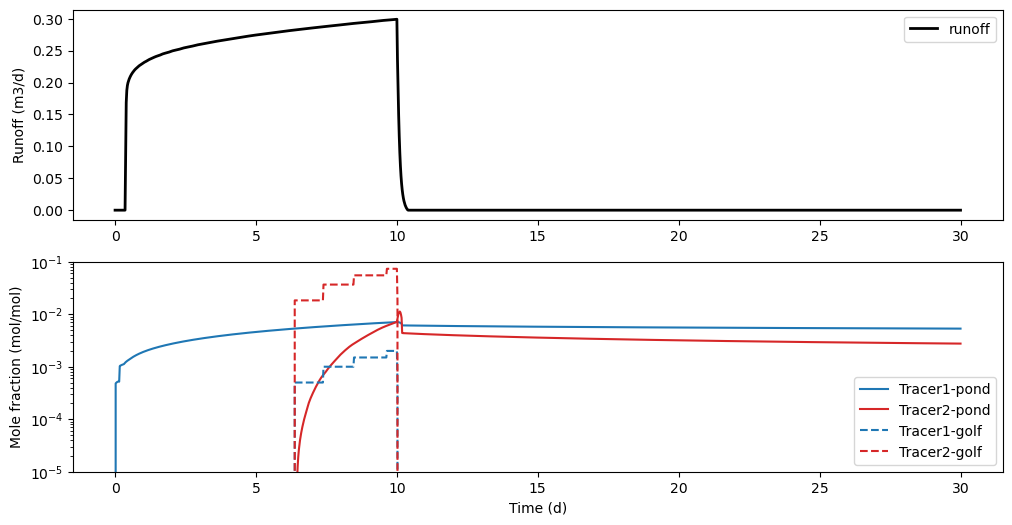

In [15]:
fname = f'{data_directory}/water_balance.dat'
num_lines = atsvis.get_skip_number(fname)

observations = pd.read_csv(fname,skiprows=num_lines,sep=",")
time_obs = observations['time [d]']
runoff = observations['runoff [mol d^-1]']
tracer1_pond = observations['surface-mole_fraction-pond Tracer1']
tracer2_pond = observations['surface-mole_fraction-pond Tracer2']
tracer1_golf = observations['surface-mole_fraction-golf Tracer1']
tracer2_golf = observations['surface-mole_fraction-golf Tracer2']
# Plot rainfall and water flux time series
fig, ax = plt.subplots(2,1,figsize=(12,6))
ax[0].plot(time_obs, runoff/55000, color='k', lw=2, label='runoff')
ax[0].set_ylabel('Runoff (m3/d)')
ax[0].legend()
ax[1].plot(time_obs, tracer1_pond, ls='-', color='tab:blue', label='Tracer1-pond')
ax[1].plot(time_obs, tracer2_pond, ls='-', color='tab:red', label='Tracer2-pond')
ax[1].plot(time_obs, tracer1_golf, ls='--', color='tab:blue', label='Tracer1-golf')
ax[1].plot(time_obs, tracer2_golf, ls='--', color='tab:red', label='Tracer2-golf')
ax[1].set_yscale('log')
ax[1].set_ylim([1e-5,1e-1])
ax[1].legend()
ax[1].set_ylabel('Mole fraction (mol/mol)')
ax[-1].set_xlabel('Time (d)')